In [1]:
import codecs
import glob
import logging
import os
import re
import scipy
import spacy
import logging
import sys
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from time import time
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import Normalizer, normalize
from sklearn.manifold import TSNE
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
%matplotlib inline
get_ipython().magic('pylab inline')

Populating the interactive namespace from numpy and matplotlib


### Introduction ###

The purpose of this challenge is to classify authors using different novels that they have written. In this case  supervised techniques have been used and compared to see which one is giving better results using tfidf and bag of words in all of them. Regarding the corpus, then authors have been chosen randomly from Gutenberg Project and 7 novels from those authors. Although initially ten novesl were picked, due to computing restrictions only seven have been left for the classification purposes. The authors that have been picked are:

1. Jane Austen
2. Chesterton
3. Conan Doyle
4. Charles Dickens
5. Elliot

In this notebook we will see the following steps:

1. Retreive and store the data creating the dataset
2. Cleanse and parse and tokenize texts
3. Generate features and select the most appropiate for the models
4. Supervised models
5. Increase the performance of one of the models by 5 percentage points

To run the supervised parts of this challenge a new virtual machine has been set up to improve the computational performance. After initial trials on the machine with increased RAM 12GB, the conditions of the challenge were too resource intensive reasing why a virtual machine 8 vCPUs, 30 GB memory was set using Google Compute Engine.

### 1. Retreive and store the data creating the dataset ###

Ten novels from four different authors have been retreived form Gutenberg project and a list of all the book files is created.

In [2]:
# Create a list of all of our book files.
book_filenames_austen = sorted(glob.glob("/home/borjaregueral/challengesuper2/austen/*.txt"))
book_filenames_chesterton = sorted(glob.glob("/home/borjaregueral/challengesuper2/chesterton/*.txt"))
book_filenames_conandoyle = sorted(glob.glob("/home/borjaregueral/challengesuper2/conandoyle/*.txt"))
book_filenames_elliot = sorted(glob.glob("/home/borjaregueral/challengesuper2/elliot/*.txt"))

The information is added to the copus and stored as raw books so that they can be cleansed

In [3]:
#Read and add the text of each book to corpus_raw.
corpus_raw_austen = u""
for book_filename in book_filenames_austen:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_austen += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_austen)))
    print()
    
#Read and add the text of each book to corpus_raw.
corpus_raw_chesterton = u""
for book_filename in book_filenames_chesterton:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_chesterton += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_chesterton)))
    print()
#Read and add the text of each book to corpus_raw.
corpus_raw_conandoyle = u""
for book_filename in book_filenames_conandoyle:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_conandoyle += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_conandoyle)))
    print()

#Read and add the text of each book to corpus_raw.
corpus_raw_elliot = u""
for book_filename in book_filenames_elliot:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_elliot += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_elliot)))
    print()

doc_complete = [corpus_raw_austen, corpus_raw_chesterton, corpus_raw_conandoyle,
                 corpus_raw_elliot]

Reading '/home/borjaregueral/challengesuper2/austen/austen-emma.txt'...
Corpus is now 795775 characters long

Reading '/home/borjaregueral/challengesuper2/austen/austen-persuasion.txt'...
Corpus is now 1262067 characters long

Reading '/home/borjaregueral/challengesuper2/chesterton/chesterton-allthingsconsidered.txt'...
Corpus is now 337425 characters long

Reading '/home/borjaregueral/challengesuper2/chesterton/chesterton-ballad.txt'...
Corpus is now 451666 characters long

Reading '/home/borjaregueral/challengesuper2/chesterton/chesterton-brown.txt'...
Corpus is now 858295 characters long

Reading '/home/borjaregueral/challengesuper2/chesterton/chesterton-orthodoxy.txt'...
Corpus is now 1218851 characters long

Reading '/home/borjaregueral/challengesuper2/conandoyle/conandoyle-adventuressh.txt'...
Corpus is now 594916 characters long

Reading '/home/borjaregueral/challengesuper2/conandoyle/conandoyle-lostworld.txt'...
Corpus is now 1046701 characters long

Reading '/home/borjareguera

In [4]:
book_file.close()

### 2. Cleanse and parse and tokenize text###

Before generating the features, and to increase the explanatory power of them, text has been cleaned and parsed accordingly. The books have gone through an initial set of cleansing actions before been parsed using Spacy, to reduce the computing effort required by the latter and then have been cleaned again before the feature generation.

The initial cleansing action has had three steps. The first step consisted on deleting all references to the Gutenberg Project from every book. This way, it has been avoided that words like “Gutenberg” and “Gutenberg Project” appear as features and distort the clustering of the authors.

As described below, cleaning actions have gone from removing all references to chapters, digits double whitespaces and references to numbers like dates and ordinal numbers. This has been followed by removing punctuation and common stop words that will only add noise to the features that are generated afterwards.

The remaining words, considered to have the most explanatory power regarding each of the titles from the authors, have been lemmatized and stemmed reducing up to 60% the computing resources needed. In the first case words from the same family are reduced to their lemmas and in the second case, additional prefixes and suffixes are removed. All cleaning operations have been carried out in a way that remaining sentences are stored in a list of lists.

In [5]:
#Create a set of stopwords in english from nltk
stop = set(stopwords.words('english'))

# Create a set of punctuation marks to exclude them from the text
exclude = set(string.punctuation) 

# Call the lemmatizer
lemma = WordNetLemmatizer()

#Define a cleaning function that incorporates the different steps in the pipeline to clean the texts
def clean(doc):
    doc = re.sub(r'--',' ',doc)
    doc = re.sub("[\[].*?[\]]", "", doc)
    doc = re.sub(r'Chapter \d+', '', doc)
    doc = re.sub(r'CHAPTER .*', '', doc)
    doc = re.sub('[0-9]+', '', doc)
    doc = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", doc)
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

#Create a list of lists with all the documents
doc_clean = [clean(doc) for doc in doc_complete]

In [6]:
# Parse the cleaned novels
#load spacy for english language as all novels are in english
nlp = spacy.load('en')

#Parse novels one by one to maintain the author tagging
austen_doc = nlp(doc_clean[0])
chesterton_doc = nlp(doc_clean[1])
conandoyle_doc = nlp(doc_clean[2])
elliot_doc = nlp(doc_clean[3])

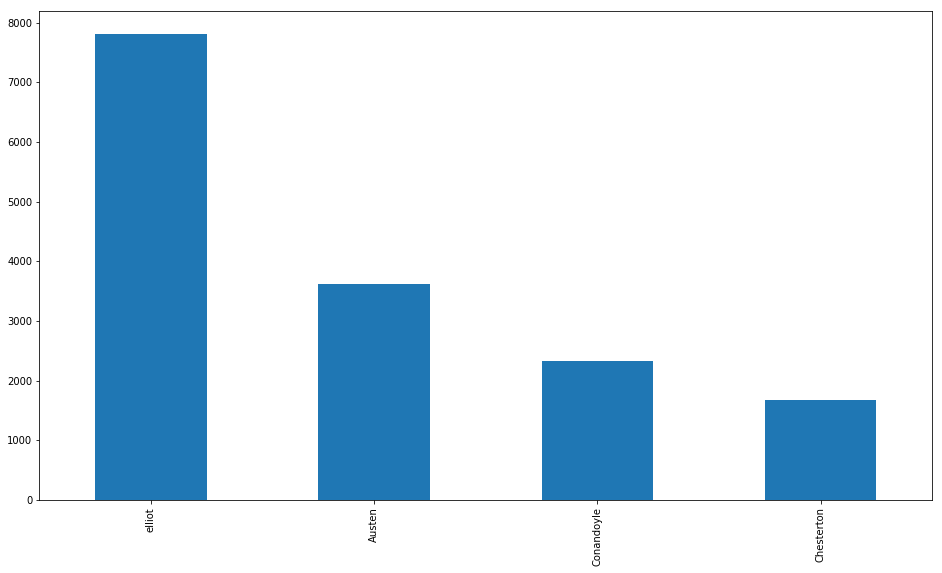

In [8]:
# Group into sentences.
austen_sents = [[str(sent), "Austen"] for sent in austen_doc.sents]
chesterton_sents = [[str(sent), "Chesterton"] for sent in chesterton_doc.sents]
conandoyle_sents = [[str(sent), "Conandoyle"] for sent in conandoyle_doc.sents]
elliot_sents = [[str(sent), "elliot"] for sent in elliot_doc.sents]

# Combine the sentences from the two novels into one data frame.
names = ['Sentences','Author']
sent = pd.DataFrame(austen_sents + chesterton_sents + 
                    conandoyle_sents + 
                    elliot_sents, columns = names)


#Plot the contribution of each author to the corpus (sentences)
sent.Author.value_counts().plot(kind='bar', grid=False, figsize=(16, 9))

In [10]:
#Aadd numerical column to tag the authors for supervised classification
sent.loc[sent['Author'] == 'Austen', 'Target'] = 0
sent.loc[sent['Author'] == 'Chesterton', 'Target'] = 1
sent.loc[sent['Author'] == 'Conandoyle', 'Target'] = 2
sent.loc[sent['Author'] == 'elliot', 'Target'] = 3

### 3. Generate features and select the most appropiate for the models ###

***Features using BoW***

Texts have been vectorized using bag of words. In this case the algorithm counts the numnber of times a word appears in a certain text. During the creation of the bag of words space, ngrams up to 4 components have been considered and stop words in english to remove noise from the dataset. Due to the authors that have been chosen, this method will bias the models towards the authors that have longer texts being Elliot and Austen compared to Conan Doyle and Chesterton. The total number of features is 52k.

In [11]:
#Transform into Bag of Words
vec = CountVectorizer(max_df = 0.75 , min_df = 2 , ngram_range = (1,4), stop_words = 'english')

#Build the predictors and the predicted variable applying BoW.
X = vec.fit_transform(sent['Sentences'])
y = sent['Target']

#Split the data set into train and test 70/30
X_train_bow, X_test_bow, y_train_bow, y_test_bow  = train_test_split(X,y, test_size=0.30, random_state=1234)

X_train_bow.shape

(10802, 52727)

***Features using Tf-idf***

When using tfidf, the frequency of appearance is normalized and also considered the ones that appear in less than 75% of the documents. With this method, the value counts are smoothen considering additional features of the word such as the amount of information it adds to describe the novel. As in the case of the ba og words, ngamrs up to four have been considered, stop words removed and thesublinear_tf used. It Apply scales the word count obtained and smoothened by the frequency of appearence in the document and whithin a document.

In [12]:
#Transform into Tf-idf considering the relative frequency
vect = TfidfVectorizer(norm = 'l2', max_df = 0.75 , min_df = 2 , ngram_range = (1,4), stop_words = 'english',
                       use_idf = True, sublinear_tf = True)

#Build the predictors and the predicted variable applying BoW.
X_tfidf = vect.fit_transform(sent['Sentences'])
y_tfidf = sent['Target']

#Split the data set into train and test 70/30
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf  = train_test_split(X_tfidf,y_tfidf, test_size=0.30, random_state=1234)

Five folds have been defined and will be used to tune and evaluate the models

In [13]:
#KFold for cross validation analysis

kf = KFold(n_splits=5, shuffle=True, random_state=123)

### 4. Supervised models ###

All models have been run using the features obtained through bag of words and tfidf. In this case results are compared to see which one gives a better overall accuracy as it has been used as the score function. In all cases cross validation over five folds is applied.

#### Logistic Regression Classifier ####

*** Bag of Words***

A Logistic Regression Classifier is trained using the features obtained through tfidf. Additionally, using fridsearch the parameters are tunned. As length of texts and therefore the features per author are not balanced, the class weight is set up so that is consideres unbalanced classes.

In [12]:
# Initialize and fit the model.
log_reg_bow = LogisticRegression(class_weight='balanced', penalty = 'l2', multi_class= 'multinomial', max_iter = 1000)

#Tune parameters: C parameter
c_param = [ 0.1, 0.5, 1 ]

#Tune the type of penalty used between l1 and l2

solver_param = ['newton-cg', 'lbfgs']

parameters = {'C': c_param, 'solver': solver_param}

#Fit parameters
log_reg_tuned_bow = GridSearchCV(log_reg_bow, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
log_reg_tuned_bow.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters logistic regression BoW:\n {}\n').format(log_reg_tuned_bow.best_params_))    

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


Best paramenters logistic regression BoW:
 {'C': 0.5, 'solver': 'newton-cg'}



After the parameters are tunned, the model is fit in the test dataset. As a measurement of the computing effort it requires 3.6 min to fit the test set.

In [13]:
#Once the model has been trained test it on the test dataset
log_reg_tuned_bow.fit(X_test_bow, y_test_bow)

# Predict on test set
predtest_y_bow = log_reg_tuned_bow.predict(X_test_bow)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.0s finished


The model is evaluated on the test set. In this case the solver has been chosen between the different options that support multiclass classification. As it can be seen in the classification report the model presents overfitting being the precision and recall close to one in all classes expect for class five (Huxley) which is the one that reduces the overall accuracy of the model.



In [14]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report BoW: \n {}')
       .format(classification_report(y_test_bow, predtest_y_bow,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_bow, predtest_y_bow)

print(('Confusion Matrix BoW: \n\n {}\n'
).format(confusion_bow))

print(('Logistic Regression set accuracy BoW: {0:.2f} % \n'
).format(cross_val_score(log_reg_tuned_bow, X_test_bow, y_test_bow,cv=kf).mean()*100
        ))

Classification Report BoW: 
              precision    recall  f1-score   support

        0.0       0.93      0.86      0.90      1091
        1.0       0.91      0.88      0.89       509
        2.0       0.94      0.87      0.90       684
        3.0       0.90      0.96      0.93      2346

avg / total       0.91      0.91      0.91      4630

Confusion Matrix BoW: 

 [[ 943    9   14  125]
 [  12  449    3   45]
 [   8    8  594   74]
 [  52   30   20 2244]]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.3s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.1s finished


Logistic Regression set accuracy BoW: 77.54 % 



The logistic regression model is computationally efficient as it fits the dataset with over 50k in less than  two minutes making it a string candidate to move intro production. The overall accuracy is nearly 77% which is roughly five percentage points more than in the challenge for this unit. The accuracy is higher than the one obainted by undsupervised methdos using clustering as is much more stable. In this case, the introduction of the test set, unseen by the model is not provoking unstable classifications.

***TF-idf***

A Logistic Regression Classifier is trained using the features obtained through tfidf. Additionally, using fridsearch the parameters are tunned. As length of texts and therefore the features per author are not balanced, the class weight is set up so that is consideres unbalanced classes. In this case the parameter of the model C is higher than the one used with the bag of words.

In [15]:
# Initialize and fit the model.

log_reg_tfidf = LogisticRegression(class_weight='balanced', penalty = 'l2', multi_class= 'multinomial', max_iter = 600)

#Tune parameters
#C parameter
c_param = [ 0.1, 0.5, 1 ]

#Tune the type of penalty used between l1 and l2

solver_param = ['newton-cg','lbfgs']

parameters = {'C': c_param, 'solver': solver_param}


#Fit parameters
log_reg_tuned_tfidf = GridSearchCV(log_reg_tfidf, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
log_reg_tuned_tfidf.fit(X_train_tfidf, y_train_tfidf)

#Print the best parameters
print(('Best paramenters logistic regression Tfidf: \n{}\n'
      ).format(log_reg_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   49.8s finished


Best paramenters logistic regression Tfidf: 
{'C': 1, 'solver': 'newton-cg'}



After the parameters are tunned, the model is fit in the test dataset. As a measurement of the computing effort it requires less than one min to fit the test set.

In [16]:
#Once the model has been trained test it on the test dataset
log_reg_tuned_tfidf.fit(X_test_tfidf, y_test_tfidf)

# Predict on test set
predtest_y_tfidf = log_reg_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.7s finished


The model is evaluated on the test set. In this case the solver has been chosen between the different options that support multiclass classification. As it can be seen in the classification report the model presents overfitting being the precision and recall close to one in all classes expect for class five (Huxley) which is the one that reduces the overall accuracy of the model.

In [17]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report Tf-idf: \n {}')
       .format(classification_report(y_test_tfidf, predtest_y_tfidf,
                          target_names=target_names)))

confusion_tfidf = confusion_matrix(y_test_tfidf, predtest_y_tfidf)

print(('Confusion Matrix Tf-idf: \n\n {}\n'
).format(confusion_tfidf))

print(('Logistic Regression set accuracy Tf-idf: {0:.2f} % \n'
).format(cross_val_score(log_reg_tuned_tfidf, X_test_tfidf, y_test_tfidf,cv=kf).mean()*100
        ))

Classification Report Tf-idf: 
              precision    recall  f1-score   support

        0.0       0.96      0.96      0.96      1091
        1.0       0.92      0.98      0.94       509
        2.0       0.96      0.95      0.96       684
        3.0       0.98      0.96      0.97      2346

avg / total       0.96      0.96      0.96      4630

Confusion Matrix Tf-idf: 

 [[1052    6    6   27]
 [   6  497    0    6]
 [   8    6  652   18]
 [  35   34   22 2255]]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.6s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.3s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.2s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.5s finished


Logistic Regression set accuracy Tf-idf: 80.43 % 



The logistic regression model is computationally efficient as it fits the dataset with over 80k in less than two minutes making it a string candidate to move intro production. The overall accuracy is nearly 80% which is roughly five percentage points more than in the challenge for this unit. The accuracy is higher than the one obainted by undsupervised methdos using clustering as is much more stable. In this case, the introduction of the test set, unseen by the model is not provoking unstable classifications.

#### Naive-Bayes Classifiers ####

***Bernoulli Classifier***

***Bag of Words ***

A Bernoulli classifier has been tunned and trained in the feautures obtained through Tf-idf. In this case the simplicity of the model added to the good classification results make of this model a good candidate to move into production. The time required to train it is lower than the time required to train the logistic regression one.

In [19]:
# Initialize and fit the model.
naive_bayes_bernoulli_bow = BernoulliNB()

#Tune hyperparameters
#Create range of values to fit parameters

alpha = [0.0001, 0.001, 0.01]
parameters = {'alpha': alpha}

#Fit parameters using gridsearch
naive_bayes_bernoulli_tuned_bow = GridSearchCV(naive_bayes_bernoulli_bow, n_jobs = -1, param_grid=parameters, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
naive_bayes_bernoulli_tuned_bow.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters logistic Naive-Bayes Bernoulli BoW: \n{}\n').format(naive_bayes_bernoulli_tuned_bow.best_params_))    

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best paramenters logistic Naive-Bayes Bernoulli BoW: 
{'alpha': 0.0001}



[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


After several runs, with different extremes in the values of the alpha parameter, the parameter chosen is always the one closer to zero. This means that the smoothing parameter is very low so the additive smoothing required is low. The model is fit within seconds which makes it a strong candidate (the best one from a computational and speed standpoint) to move intro production.

In [20]:
#Once the model has been trained test it on the test dataset
naive_bayes_bernoulli_tuned_bow.fit(X_test_bow, y_test_bow)

# Predict on test set
predtest_y_bow = naive_bayes_bernoulli_tuned_bow.predict(X_test_bow)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


The model is evaluated using cross validation and five folds. In this case as in the case of logistic regression the model presents overfitting as it can be seen from the classification report. Both precision and recall is one for this reason.

In [21]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report BoW: \n {}\n').format(
    classification_report(y_test_bow, predtest_y_bow,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_bow, predtest_y_bow)

print(('Confusion Matrix BoW: \n\n {}\n\n').format(confusion_bow))

print(('Bernoulli Classifier set accuracy BoW: {0:.2f} %\n').format(cross_val_score(naive_bayes_bernoulli_tuned_bow,
                                                                                X_test_bow,
                                                                                y_test_bow,cv=kf).mean()*100))

Classification Report BoW: 
              precision    recall  f1-score   support

        0.0       0.99      0.88      0.93      1091
        1.0       1.00      0.74      0.85       509
        2.0       1.00      0.77      0.87       684
        3.0       0.85      1.00      0.92      2346

avg / total       0.92      0.91      0.91      4630


Confusion Matrix BoW: 

 [[ 958    0    0  133]
 [   6  376    0  127]
 [   5    0  527  152]
 [   0    0    0 2346]]


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Bernoulli Classifier set accuracy BoW: 81.75 %



[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


The overall accuracy of the model is slightly lower than the accuracy obtained with the logistic regression classifier. However, the time required to fit the model is at least one tenth of the time required for the logistic regression presenting both overfitting. Hence, if overall accuracy is what is tried to be improved, this is the best model with a very small loss of accuracy scoring 81.75%.

*** Tf-idf***

A Bernoulli classifier has been tunned and trained in the feautures obtained through Tf-idf. In this case the simplicity of the model added to the good classification results make of this model a good candidate to move into production. The time required to train it is lower than the time required to train the logistic regression one.

In [22]:
# Initialize and fit the model.
naive_bayes_bernoulli_tfidf = BernoulliNB()

#Tune hyperparameters
#Create range of values to fit parameters

alpha = [0.001, 0.01,0.1]
parameters = {'alpha': alpha}

#Fit parameters using gridsearch
naive_bayes_bernoulli_tuned_tfidf = GridSearchCV(naive_bayes_bernoulli_tfidf,
                                                 n_jobs = -1,
                                                 param_grid=parameters,
                                                 cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
naive_bayes_bernoulli_tuned_tfidf.fit(X_train_tfidf, y_train_tfidf)

#Print the best parameters
print(('Best paramenters logistic Naive-Bayes Bernoulli Tfidf: \n{}\n').format(naive_bayes_bernoulli_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best paramenters logistic Naive-Bayes Bernoulli Tfidf: 
{'alpha': 0.001}



[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


After several runs, with different extremes in the values of the alpha parameter, the parameter chosen is always the one closer to zero. This means that the smoothing parameter is very low so the additive smoothing required is low. The model is fit within seconds which makes it a strong candidate (the best one from a computational and speed standpoint) to move intro production.

In [23]:
#Once the model has been trained test it on the test dataset
naive_bayes_bernoulli_tuned_tfidf.fit(X_test_tfidf, y_test_tfidf)

# Predict on test set
predtest_y_tfidf = naive_bayes_bernoulli_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


he model is evaluated using cross validation and five folds. In this case as in the case of logistic regression the model presents overfitting as it can be seen from the classification report. Both precision and recall is one for this reason.

In [24]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report Tfidf: \n {}').format(classification_report(y_test_tfidf, predtest_y_tfidf,
                          target_names=target_names)))

confusion_tfidf = confusion_matrix(y_test_tfidf, predtest_y_tfidf)

print(('Confusion Matrix Tf-idf: \n\n {}\n').format(confusion_tfidf))

print(('Bernoulli Classifier Tf-Idf set accuracy Tf-idf: {0:.2f} % \n').format(cross_val_score(naive_bayes_bernoulli_tuned_tfidf,
                                                                                       X_test_tfidf,
                                                                                       y_test_tfidf,
                                                                                       cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       0.99      0.88      0.93      1091
        1.0       1.00      0.72      0.83       509
        2.0       1.00      0.75      0.86       684
        3.0       0.84      1.00      0.91      2346

avg / total       0.92      0.90      0.90      4630

Confusion Matrix Tf-idf: 

 [[ 957    0    0  134]
 [   6  364    0  139]
 [   6    0  515  163]
 [   0    0    0 2346]]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Bernoulli Classifier Tf-Idf set accuracy Tf-idf: 81.58 % 



[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


The overall accuracy of the model is slightly higher than the accuracy obtained with the logistic regression classifier (81.58%). However, the time required to fit the model is at least one tenth of the time required for the logistic regression presenting both overfitting. In this case is class seven (Shaw) the one that shows the lowest precision being the one that determines the lower value of the overall accuracy when compared to the Bernoulli model. Hence, if overall accuracy is what is tried to be improved, this is the best model with a very small loss of accuracy

***Multinomial Classifier***

***BoW***

A multinomial classifier is trained on the features obtained using tfidf and evaluated on the holdout. In this case, as in the previous Navy Bayes classification used, alpha always gets the value cloaer to zero, therefore there is no additive smoothing used in this classifier. From a compuational effort standpoint, as in the previous case, this is the one that requires less time to fit making it a strong candidate to move into production.

In [25]:
# Initialize and fit the model.
naive_bayes_multinomial_bow = MultinomialNB()

#Tune hyperparameters
#Create range of values to fit parameters

alpha = [0.01,0.1,0.5]
parameters = {'alpha': alpha}

#Fit parameters using gridsearch
naive_bayes_multinomial_tuned_bow = GridSearchCV(naive_bayes_multinomial_bow,
                                                 n_jobs = -1,
                                                 param_grid=parameters,
                                                 cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
naive_bayes_multinomial_tuned_bow.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters Naive-Bayes Multinomial BoW:\n {}\n').format(
naive_bayes_multinomial_tuned_bow.best_params_))    

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best paramenters Naive-Bayes Multinomial BoW:
 {'alpha': 0.5}



[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


The value of alpha is in all trials the closest one to zero being the additive smoothing lose. In this case the time required for fitting is less than one minute. The model is then evaluated on the test set. For that, the first step is to fit the test hodout of the dataset.

In [26]:
#Once the model has been trained test it on the test dataset
naive_bayes_multinomial_tuned_bow.fit(X_test_bow, y_test_bow)

# Predict on test set
predtest_y_bow = naive_bayes_multinomial_tuned_bow.predict(X_test_bow)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


The model presents overfitting and the accuracy is slightly higher than in the previous case 3% more. The confusion matrix presents a lower number of false positives and negatives for all categories, taking into account that the size of each of them is different results are consistent across all of them.

In [27]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report BoW: \n {}\n').format(
    classification_report(y_test_bow, predtest_y_bow,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_bow, predtest_y_bow)

print((
    'Confusion Matrix BoW: \n\n {}\n\n').format(confusion_bow))

print((
    'Multinomial Classifier set accuracy BoW: {0:.2f} %\n'
).format(cross_val_score(naive_bayes_multinomial_tuned_bow, X_test_bow, y_test_bow,cv=kf).mean()*100))

Classification Report BoW: 
              precision    recall  f1-score   support

        0.0       0.95      0.91      0.93      1091
        1.0       0.97      0.85      0.90       509
        2.0       0.99      0.82      0.90       684
        3.0       0.90      0.99      0.94      2346

avg / total       0.93      0.93      0.93      4630


Confusion Matrix BoW: 

 [[ 995    2    1   93]
 [  12  432    3   62]
 [  22   10  562   90]
 [  23    3    3 2317]]


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Multinomial Classifier set accuracy BoW: 84.13 %



[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


The time required to fit the model is lower than in any other case presenting a higher accuracy. In this case, the accuracy is close to 84.12% while the classification report shows values close to one, showing that there is overfitting. Hence, from the classifiers evaluated until now this is the one that presents better results, from an accuracy and a computational effort perspective. This is the best candidate to move into production for the moment.

***Tf-idf***

A multinomial classifier is trained on the features obtained using tfidf and evaluated on the holdout. In this case, as in the previous Navy Bayes classification used, alpha always gets the value cloaer to zero, therefore there is no additive smoothing used in this classifier. From a compuational effort standpoint, as in the previous case, this is the one that requires less time to fit making it a strong candidate to move into production.

In [28]:
# Initialize and fit the model.
naive_bayes_multinomial_tfidf = MultinomialNB()

#Tune hyperparameters
#Create range of values to fit parameters

alpha = [0.01,0.1,0.5,1]
parameters = {'alpha': alpha}

#Fit parameters using gridsearch
naive_bayes_multinomial_tuned_tfidf = GridSearchCV(naive_bayes_multinomial_tfidf,
                                                 n_jobs = -1,
                                                 param_grid=parameters,
                                                 cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
naive_bayes_multinomial_tuned_tfidf.fit(X_train_tfidf, y_train_tfidf)

#Print the best parameters
print(('Best paramenters Naive-Bayes Multinomial BoW:\n {}\n').format(
naive_bayes_multinomial_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


Best paramenters Naive-Bayes Multinomial BoW:
 {'alpha': 0.01}



he value of alpha is in all trials the closest one to zero being the additive smoothing lose. In this case the time required for fitting is less than one minute. The model is then evaluated on the test set. For that, the first step is to fit the test hodout of the dataset.

In [29]:
#Once the model has been trained test it on the test dataset
naive_bayes_multinomial_tuned_tfidf.fit(X_test_tfidf, y_test_tfidf)

# Predict on test set
predtest_y_tfidf = naive_bayes_multinomial_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


The model presents overfitting and the accuracy is slightly higher than in the previous case 3% more. The confusion matrix presents a lower number of false positives and negatives for all categories, taking into account that the size of each of them is different results are consistent across all of them.

In [30]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report tfidf: \n {}').format(classification_report(y_test_tfidf,
                                                                          predtest_y_tfidf,
                                                                          target_names=target_names)))

confusion_tfidf = confusion_matrix(y_test_tfidf, predtest_y_tfidf)

print(('Confusion Matrix Tf-idf: \n\n {}\n').format(confusion_tfidf))

print(('Multinomial Classifier set accuracy Tf-idf: {0:.2f} % \n').format(cross_val_score(naive_bayes_multinomial_tuned_tfidf,
                                                                                       X_test_tfidf,
                                                                                       y_test_tfidf,
                                                                                       cv=kf).mean()*100))

Classification Report tfidf: 
              precision    recall  f1-score   support

        0.0       0.97      0.96      0.96      1091
        1.0       1.00      0.92      0.95       509
        2.0       1.00      0.91      0.95       684
        3.0       0.95      0.99      0.97      2346

avg / total       0.97      0.97      0.97      4630

Confusion Matrix Tf-idf: 

 [[1052    0    0   39]
 [   8  466    0   35]
 [  11    0  625   48]
 [  19    1    0 2326]]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Multinomial Classifier set accuracy Tf-idf: 83.67 % 



[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


The time required to fit the model is lower than in any other case presenting a higher accuracy. In this case, the accuracy is close to 83.67% while the classification report shows values close to one, showing that there is overfitting. Hence, from the classifiers evaluated until now this is the one that presents better results, from an accuracy and a computational effort perspective. This is the best candidate to move into production for the moment.

#### KNN Classifier ####

***Bag of Words***

The KNN classifier has been fit using bag of words. In this case during the gridsearch, five neighbors have been selected as the optimumm number of neighbors when using bag of words

In [31]:
# Initialize and fit the model.
KNN_bow = KNeighborsClassifier(weights = 'distance')

#Tune hyperparameters
#Create range of values to fit parameters

neighbors = [3, 5, 7,9]

#Fit parameters
parameters = {'n_neighbors': neighbors}

#Fit parameters using gridsearch
KNN_tuned_bow = GridSearchCV(KNN_bow, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
KNN_tuned_bow.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters KNN BoW:\n {}\n').format(
KNN_tuned_bow.best_params_))    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best paramenters KNN BoW:
 {'n_neighbors': 5}



[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.9s finished


Once the model has been tuned, it is fit in the test holdout

In [32]:
#Once the model has been trained test it on the test dataset
KNN_tuned_bow.fit(X_test_bow, y_test_bow)

# Predict on test set
predtest_y_bow = KNN_tuned_bow.predict(X_test_bow)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.6s finished


The evaluation of the model is done using the classification report, confusion matrix and overall accuracy. In this case KNN works worse than other models as it does not have enough data. From the classification report it can be seen that the model is not overfitting having a high but not equal to one precision and recall. Author two is the one that is scoring the worst results.

In [33]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report BoW: \n {}\n').format(
    classification_report(y_test_bow, predtest_y_bow,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_bow, predtest_y_bow)

print((
    'Confusion Matrix BoW: \n\n {}\n\n').format(confusion_bow))

print((
    'KNN accuracy BoW: {0:.2f} %\n'
).format(cross_val_score(KNN_tuned_bow, X_test_bow, y_test_bow,cv=kf).mean()*100))

Classification Report BoW: 
              precision    recall  f1-score   support

        0.0       0.98      0.99      0.98      1091
        1.0       0.98      0.98      0.98       509
        2.0       0.99      0.96      0.98       684
        3.0       0.99      0.99      0.99      2346

avg / total       0.98      0.98      0.98      4630


Confusion Matrix BoW: 

 [[1081    1    0    9]
 [   6  498    0    5]
 [   7    2  656   19]
 [  12    6    4 2324]]


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits
KNN accuracy BoW: 59.72 %



[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished


The model is scoring really low from the accuracy that is normally achieved when using KNN. One of the reaons is the amount of data used to fit the model.

***Tf- idf***

The model is fit on the training set using the features obtained using tfidf. In this case the tuning of the model give lower parameters as the features have been already smoothened being the number of neighbors equal to three.

In [14]:
# Initialize and fit the model.
KNN_tfidf = KNeighborsClassifier(weights = 'distance')

#Tune hyperparameters
#Create range of values to fit parameters

neighbors = [3, 5, 7,9]

#Fit parameters
parameters = {'n_neighbors': neighbors}

#Fit parameters using gridsearch
KNN_tuned_tfidf = GridSearchCV(KNN_tfidf,
                               param_grid=parameters,
                               n_jobs = -1,
                               cv=kf,
                               verbose = 1)

#Fit the tunned classifier in the training space
KNN_tuned_tfidf.fit(X_train_tfidf, y_train_tfidf)

#Print the best parameters
print(('Best paramenters KNN Tfidf:\n {}\n').format(KNN_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best paramenters KNN Tfidf:
 {'n_neighbors': 3}



[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.5s finished


Once the parameters are tuned the model is fit on the test set.

In [15]:
#Once the model has been trained test it on the test dataset
KNN_tuned_tfidf.fit(X_test_tfidf, y_test_tfidf)

# Predict on test set
predtest_y_tfidf = KNN_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished


In this case, the accuracy obtained with tfidf is not very different from the accuracy obtained with the bag of words. Better results would be obtained if more data is used to run the model

In [16]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report Tfidf: \n {}\n').format(
    classification_report(y_test_tfidf, predtest_y_tfidf,
                          target_names=target_names)))

confusion_tfidf = confusion_matrix(y_test_tfidf, predtest_y_tfidf)

print((
    'Confusion Matrix Tfidf: \n\n {}\n\n').format(confusion_tfidf))

print((
    'KNN accuracy Tfidf: {0:.2f} %\n'
).format(cross_val_score(KNN_tuned_tfidf, X_test_tfidf, y_test_tfidf,cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       0.98      0.99      0.98      1091
        1.0       0.98      0.98      0.98       509
        2.0       0.99      0.96      0.98       684
        3.0       0.99      0.99      0.99      2346

avg / total       0.98      0.98      0.98      4630


Confusion Matrix Tfidf: 

 [[1081    1    0    9]
 [   6  497    0    6]
 [   7    2  656   19]
 [  12    6    4 2324]]


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.7s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.7s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.7s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.8s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.7s finished


KNN accuracy Tfidf: 51.75 %



Regarding the time used by this model, it is unexpectedly low as it runs over a small dataset. This is the reason why the values obtained are so low when compared to the results obtained through the bag of words.

#### SDG Classifier ####

***Bag of Words***

The SDG classifier is fit on the training set. The SGD Classifier uses regularized linear models with stochastic gradient descendent learning. The model is updated in its learning rate after the gradient of the loss is estaimated for each sample. This classifier can work with sparse data se the one obtained from bag of words. In this case from the types of penalties the algorithm accepts, it uses L2 instead of a combination of L! and L2 implemented through Elastic Net. 

In [37]:
# Initialize and fit the model.
SGD_bow = SGDClassifier(class_weight = 'balanced', max_iter=1000)

#Tune hyperparameters
#Create range of values to fit parameters

loss_param = ['hinge', 'squared_hinge']
penalty_param = ['l2', 'elasticnet']
alpha_param = [0.1, 1, 10, 100]

#Fit parameters
parameters = {'loss': loss_param,
              'penalty': penalty_param,
              'alpha': alpha_param}

#Fit parameters using gridsearch
SGD_tuned_bow = GridSearchCV(SGD_bow, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
SGD_tuned_bow.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters SGD BoW:\n {}\n').format(
SGD_tuned_bow.best_params_))    

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.7min finished


Best paramenters SGD BoW:
 {'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l2'}



The parameters show that the smooting continues to be loose as a first option as it is a regression with a gradient descendent algorithm. Regarding the loss, the hinge loss is used which means that the real loss, in case it is not convergent due to the sparse data used is replaced by the upper bond forcing its convergence. Time required is significanlty higher than in the case of the Naive Bayes classifiers

In [38]:
#Once the model has been trained test it on the test dataset
SGD_tuned_bow.fit(X_test_bow, y_test_bow)

# Predict on test set
predtest_y_bow = SGD_tuned_bow.predict(X_test_bow)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished


This model presents overfitting as all precision and recall are equal to one for every class. The confusion matrix shows a lower number of false negatives and positives per class being more or less evenly represented except for class three.

In [39]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report BoW: \n {}\n').format(
    classification_report(y_test_bow, predtest_y_bow,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_bow, predtest_y_bow)

print((
    'Confusion Matrix BoW: \n\n {}\n\n').format(confusion_bow))

print((
    'SGD accuracy BoW: {0:.2f} %\n'
).format(cross_val_score(SGD_tuned_bow, X_test_bow, y_test_bow,cv=kf).mean()*100))

Classification Report BoW: 
              precision    recall  f1-score   support

        0.0       0.84      0.65      0.73      1091
        1.0       0.89      0.53      0.67       509
        2.0       0.98      0.44      0.61       684
        3.0       0.71      0.97      0.82      2346

avg / total       0.80      0.77      0.75      4630


Confusion Matrix BoW: 

 [[ 713    8    3  367]
 [  34  270    3  202]
 [  37    9  302  336]
 [  66   15    1 2264]]


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


SGD accuracy BoW: 72.57 %



In this case, the overall accuracy is 72.57%, very similar to the overall accuracy obtained using the multinomial classifier. The computational effort required by this model to achieve this accuracy is much higher than in the case of the multinomial classifier. Hence, from a production perspective, this model would not be recommended to move into production despite of its high accuracy.

***Tf- idf ***

The SGD Classifier uses regularized linear models with stochastic gradient descendent learning. The model is updated in its learning rate after the gradient of the loss is estaimated for each sample. This classifier can work with sparse data se the one obtained from tfidf. In this case from the types of penalties the algorithm accepts, it uses L2 instead of a combination of L! and L2 implemented through Elastic Net. 

In [40]:
# Initialize and fit the model.
SGD_tfidf = SGDClassifier(class_weight = 'balanced', max_iter=1000)

#Tune hyperparameters
#Create range of values to fit parameters

loss_param = ['hinge', 'squared_hinge']
penalty_param = ['elasticnet', 'l2' ]
alpha_param = [1, 0.0001, 0.001, 0.01, 0.1]

#Fit parameters
parameters = {'loss': loss_param,
              'penalty': penalty_param,
              'alpha': alpha_param}

#Fit parameters using gridsearch
SGD_tuned_tfidf = GridSearchCV(SGD_tfidf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
SGD_tuned_tfidf.fit(X_train_tfidf, y_train_tfidf)

#Print the best parameters
print(('Best paramenters SDG Tfidf:\n {}\n').format(
SGD_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


Best paramenters SDG Tfidf:
 {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'elasticnet'}



The parameters show that the smooting continues to be loose as a first option as it is a regression with a gradient descendent algorithm. Regarding the loss, the hinge loss is used which means that the real loss, in case it is not convergent due to the sparse data used is replaced by the upper bond forcing its convergence. Time required is significanlty higher than in the case of the Naive Bayes classifiers

In [41]:
#Once the model has been trained test it on the test dataset
SGD_tuned_tfidf.fit(X_test_tfidf, y_test_tfidf)

# Predict on test set
predtest_y_tfidf = SGD_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


This model presents overfitting as all precision and recall are equal to one for every class. The confusion matrix shows a lower number of false negatives and positives per class being more or less evenly represented except for class one.

In [42]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report Tfidf: \n {}\n').format(
    classification_report(y_test_tfidf, predtest_y_tfidf,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_tfidf, predtest_y_tfidf)

print((
    'Confusion Matrix Tfidf: \n\n {}\n\n').format(confusion_tfidf))

print((
    'SGD accuracy Tfidf: {0:.2f} %\n'
).format(cross_val_score(SGD_tuned_tfidf, X_test_tfidf, y_test_tfidf,cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       0.95      0.96      0.95      1091
        1.0       0.91      0.97      0.94       509
        2.0       0.98      0.93      0.95       684
        3.0       0.97      0.97      0.97      2346

avg / total       0.96      0.96      0.96      4630


Confusion Matrix Tfidf: 

 [[1081    1    0    9]
 [   6  497    0    6]
 [   7    2  656   19]
 [  12    6    4 2324]]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


SGD accuracy Tfidf: 80.78 %



In this case, the overall accuracy is 80.78%, very similar to the overall accuracy obtained using the multinomial classifier. The computational effort required by this model to achieve this accuracy is much higher than in the case of the multinomial classifier . Hence, from a production perspective, this model would not be recommended to move into production despite of its high accuracy.

#### Random Forest ####

*** Bag of Words***

The hyperparamters of the random forest model have been tuned one by one. After trying to tune them all at once, a significant increase of the overall performance of the classifier was obtained with the proposed method (one by one). The parameters to be tuned are (in the same order as the hyperparameter tuning has been performed):

N_estimators determining the number of trees that will be part of the algorithm.
Max depth determining the size of the tree.

In [49]:
# Initialize and fit the model.
rf_bow = RandomForestClassifier(class_weight = 'balanced')

#Tune hyperparameters
#Create range of values to fit parameters

n_estimators_param = np.arange(250,401,20)
max_depth_param = np.arange(46,63,2)

#Fit parameters
parameters = {'n_estimators': n_estimators_param,
              'max_depth': max_depth_param}

#Fit parameters using gridsearch
rf_tuned_bow = GridSearchCV(rf_bow, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
rf_tuned_bow.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters Random Forest BoW:\n {}\n').format(rf_tuned_bow.best_params_))    

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 31.6min finished


Best paramenters Random Forest BoW:
 {'max_depth': 56, 'n_estimators': 350}



The tuned model is fit and run on the test set

In [50]:
#Once the model has been trained test it on the test dataset
rf_tuned_bow.fit(X_test_bow, y_test_bow)

# Predict on test set
predtest_y_bow = rf_tuned_bow.predict(X_test_bow)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 14.8min finished


The overall accuracy of the model has significantly increase compared to the previous classifiers achieving 73%. This result is low for the type of classifier used. Additionally it is lower than the results obtained with other classifiers. In this case, author seven is the one that is decreasig the overall accuracy.

In [51]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report BoW: \n {}\n').format(
    classification_report(y_test_bow, predtest_y_bow,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_bow, predtest_y_bow)

print((
    'Confusion Matrix BoW: \n\n {}\n\n').format(confusion_bow))

print((
    'Random Forest accuracy BoW: {0:.2f} %\n'
).format(cross_val_score(rf_tuned_bow, X_test_bow, y_test_bow,cv=kf).mean()*100))

Classification Report BoW: 
              precision    recall  f1-score   support

        0.0       0.94      0.80      0.87      1091
        1.0       0.99      0.74      0.85       509
        2.0       1.00      0.73      0.84       684
        3.0       0.82      0.99      0.90      2346

avg / total       0.90      0.88      0.88      4630


Confusion Matrix BoW: 

 [[ 871    0    0  220]
 [  16  378    0  115]
 [  10    2  497  175]
 [  25    0    0 2321]]


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 12.0min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 12.0min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 12.2min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 12.2min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 12.3min finished


Random Forest accuracy BoW: 77.65 %



This classifier requires more time to run than the Naive Bayes ones and throws poorer results than them. Author three is the one that is reducing the overall accuracy.

*** Tf-idf***

The hyperparamters of the random forest model have been tuned one by one. After trying to tune them all at once, a significant increase of the overall performance of the classifier was obtained with the proposed method (one by one). The parameters to be tuned are (in the same order as the hyperparameter tuning has been performed):

N_estimators determining the number of trees that will be part of the algorithm.
Max depth determining the size of the tree.

In [52]:
# Initialize and fit the model.
rf_tfidf = RandomForestClassifier(class_weight = 'balanced')

#Tune hyperparameters
#Create range of values to fit parameters

n_estimators_param = np.arange(100,201,10)
max_depth_param = np.arange(50,71,5)

#Fit parameters
parameters = {'n_estimators': n_estimators_param,
              'max_depth': max_depth_param}

#Fit parameters using gridsearch
rf_tuned_tfidf = GridSearchCV(rf_tfidf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
rf_tuned_tfidf.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters Random Forest Tfidf:\n {}\n').format(
rf_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed: 13.6min finished


Best paramenters Random Forest Tfidf:
 {'max_depth': 55, 'n_estimators': 180}



The tuned model is fit and run on the test set

In [53]:
#Once the model has been trained test it on the test dataset
rf_tuned_tfidf.fit(X_test_tfidf, y_test_tfidf)

# Predict on test set
predtest_y_tfidf = rf_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  6.7min finished


The overall accuracy of the model has significantly increase compared to the previous classifiers achieving 73%. This result is low for the type of classifier used. Additionally it is lower than the results obtained with other classifiers. In this case, author seven is the one that is decreasig the overall accuracy.

In [54]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report Tfidf: \n {}\n').format(
    classification_report(y_test_tfidf, predtest_y_tfidf,
                          target_names=target_names)))

confusion_tfidf = confusion_matrix(y_test_tfidf, predtest_y_tfidf)

print((
    'Confusion Matrix Tfidf: \n\n {}\n\n').format(confusion_tfidf))

print((
    'Random Forest accuracy Tfidf: {0:.2f} %\n'
).format(cross_val_score(rf_tuned_tfidf, X_test_tfidf, y_test_tfidf,cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       0.95      0.81      0.88      1091
        1.0       1.00      0.76      0.86       509
        2.0       1.00      0.74      0.85       684
        3.0       0.83      0.99      0.90      2346

avg / total       0.90      0.88      0.88      4630


Confusion Matrix Tfidf: 

 [[ 883    0    0  208]
 [  14  386    1  108]
 [   8    0  503  173]
 [  21    0    0 2325]]


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  5.3min finished


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  5.2min finished


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  5.3min finished


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  5.3min finished


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  5.3min finished


Random Forest accuracy Tfidf: 76.93 %



This classifier requires more time to run than the Naive Bayes ones and throws poorer results than them. Author three is the one that is reducing the overall accuracy.

#### SVC ####

***Bag of Words ***

A linear support vector classifier has been set up and tuned on the training data and run on the test set. The hyperparameters that have been tuned are:

C parameter, acting on the margin hyperplane having a bigger margin when C is smaller. (The value of C will tell the SVM how much misclassification is to be avoided).
The loss parameter.
In this case the crammer singer algorithm is used to solve the multiclass classification problem. This algorithm optimizes the joint objective over all classes but it is not interesting from a production standpoint as it rarely leads to better accuracy and is more expensive to compute. Due to the size of the feature´s space the linear SVC has been used instead of the SVC due to computational restrictions.



In [60]:
# Initialize and fit the model.
LSVC_bow = LinearSVC(class_weight='balanced', multi_class = 'crammer_singer')

#Tune hyperparameters
#Create range of values to fit parameters


loss_param = ['hinge','squared_hinge']
C_param = [1, 10, 100, 100000]

#Fit parameters
parameters = { 'loss': loss_param,
             'C': C_param}

#Fit parameters using gridsearch
LSVC_tuned_bow = GridSearchCV(LSVC_bow, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
LSVC_tuned_bow.fit(X_train_bow, y_train_bow)

#Print the best parameters
print(('Best paramenters LinearSVC BoW:\n {}\n').format(
LSVC_tuned_bow.best_params_))    

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.0min finished


Best paramenters LinearSVC BoW:
 {'C': 1, 'loss': 'squared_hinge'}



Once the parameters have been tunned the model is fit in the testing dataset

In [61]:
#Once the model has been trained test it on the test dataset
LSVC_tuned_bow.fit(X_test_bow, y_test_bow)

# Predict on test set
predtest_y_bow = LSVC_tuned_bow.predict(X_test_bow)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


Although from a computational perspective it requires more effort, it presents better results than the previous algorithms. In this case, nearly 73% has been achieved competing agasint the multiclass algorithm in terms of accuracy but not in terms of computational effort.

In [62]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report BoW: \n {}\n').format(
    classification_report(y_test_bow, predtest_y_bow,
                          target_names=target_names)))

confusion_bow = confusion_matrix(y_test_bow, predtest_y_bow)

print((
    'Confusion Matrix BoW: \n\n {}\n\n').format(confusion_bow))

print((
    'Linear SVC accuracy BoW: {0:.2f} %\n'
).format(cross_val_score(LSVC_tuned_bow, X_test_bow, y_test_bow,cv=kf).mean()*100))

Classification Report BoW: 
              precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1091
        1.0       0.98      0.98      0.98       509
        2.0       0.98      0.96      0.97       684
        3.0       0.98      0.98      0.98      2346

avg / total       0.98      0.98      0.98      4630


Confusion Matrix BoW: 

 [[1076    2    3   10]
 [   5  497    0    7]
 [   6    2  654   22]
 [  18    8   10 2310]]


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.9min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.9min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.8min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Linear SVC accuracy BoW: 72.27 %



The algorithm presents overfitting as it can be seen from the classification report. Although recall and precision are one, in reality they are lower than one having an overall accuracy of 79.37%. Furthermore, the time required to fit the dataset is higher than the one required wuth the Naive Bayes algorithms.

***Tf-idf***

A linear support vector classifier has been set up and tuned on the training data and run on the test set. The hyperparameters that have been tuned are:

  C parameter, acting on the margin hyperplane having a bigger margin when C is smaller. (The value of C will tell the SVM how   much misclassification is to be avoided).
   The loss parameter.
In this case the crammer singer algorithm is used to solve the multiclass classification problem. This algorithm optimizes the joint objective over all classes but it is not interesting from a production standpoint as it rarely leads to better accuracy and is more expensive to compute. Due to the size of the feature´s space the linear SVC has been used instead of the SVC due to computational restrictions.

In [65]:
# Initialize and fit the model.
LSVC_tfidf = LinearSVC(class_weight='balanced', multi_class = 'crammer_singer')

#Tune hyperparameters
#Create range of values to fit parameters

loss_param = ['hinge','squared_hinge']
C_param = [0.1, 1, 10, 100]

#Fit parameters
parameters = {
              'loss': loss_param,
             'C': C_param}

#Fit parameters using gridsearch
LSVC_tuned_tfidf = GridSearchCV(LSVC_tfidf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
LSVC_tuned_tfidf.fit(X_train_tfidf, y_train_tfidf)

#Print the best parameters
print(('Best paramenters Linear SVC Tfidf:\n {}\n').format(LSVC_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   17.8s finished


Best paramenters Linear SVC Tfidf:
 {'C': 0.1, 'loss': 'squared_hinge'}



Once the parameters have been tunned the model is fit in the testing dataset

In [66]:
#Once the model has been trained test it on the test dataset
LSVC_tuned_tfidf.fit(X_test_tfidf, y_test_tfidf)

# Predict on test set
predtest_y_tfidf = LSVC_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.1s finished


Although from a computational perspective it requires more effort, it presents better results than the previous algorithms. In this case, nearly 79% has been achieved competing agasint the multiclass algorithm in terms of accuracy but not in terms of computational effort.

In [67]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0', '2.0', '3.0']

print(('Classification Report Tfidf: \n {}\n').format(
    classification_report(y_test_tfidf, predtest_y_tfidf,
                          target_names=target_names)))

confusion_tfidf = confusion_matrix(y_test_tfidf, predtest_y_tfidf)

print((
    'Confusion Matrix Tfidf: \n\n {}\n\n').format(confusion_tfidf))

print((
    'Linear SVC accuracy Tfidf: {0:.2f} %\n'
).format(cross_val_score(LSVC_tuned_tfidf, X_test_tfidf, y_test_tfidf,cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       0.96      0.99      0.98      1091
        1.0       0.95      0.98      0.97       509
        2.0       0.97      0.96      0.97       684
        3.0       0.99      0.97      0.98      2346

avg / total       0.98      0.98      0.98      4630


Confusion Matrix Tfidf: 

 [[1078    2    3    8]
 [   6  499    0    4]
 [   6    3  659   16]
 [  28   19   15 2284]]


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.8s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.3s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.3s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.8s finished


Linear SVC accuracy Tfidf: 79.37 %



The algorithm presents overfitting as it can be seen from the classification report. Although recall and precision are one, in reality they are lower than one having an overall accuracy of 79.37%. Furthermore, the time required to fit the dataset is higher than the one required wuth the Naive Bayes algorithms.

### 5. Improve accuracy of one of the models ###

The accuracy improvement of all of the models has been done in the capstone project. To achieve this improvement the steps that have been taken have been:
    
1. Increase the dataset per author
2. Increase the steps and the cleansing of the texts.
3. Improve the feature generation and selection using tf-idf
    
The results obtained once all the stepst have been taken are:
        
 1. SGD Classifier: 87.12%
 2. Multinomial Classifier: 87.02%
 3. Linear Support Vector Machine: 86.48%
 4. Logistic Regression: 84.88%
 5. Bernouilli Classifier: 82.53%
 6. Random Forest: 73.34%
 7. KNN: 68.05%.
 
From the initial set of results obtained in this challenge:

1. Multinomial Classifier: 84.13% (BoW) & 83.46 (Tfidf)
2. Bernoulli Classifier: 81.75% (BoW) & 81.58% (Tfidf)
3. Random Forest: 77.64 (Bow) & 76.93% (Tfidf) 
3. Logistic Regression: 77.54 (Bow) & 80.43% (Tfidf) 
4. SGD Clasifier: 72.57% (BoW) & 80.78% (Tfidf)
5. Support Vector Machine: 72.27% (BoW) & 79.37% (Tfidf)
6. KNN: 59.72% (Bow) & 51,75 (Tfidf)

From all the improvements made,  I pick up the one made in the SGD classifier that goes from 80.78% to 87.12%. The changes made in the model can be seen in the capstone project.